In [40]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


# Import Libraries

In [41]:
%pip install -q pyunpack
from pyunpack import Archive
import numpy as np
import pandas as pd
import os
import seaborn as sns
import cv2
from PIL import Image
import glob as gb
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import models, regularizers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Activation, MaxPooling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Input, BatchNormalization, Dropout, ZeroPadding2D
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
sns.set(rc={'figure.figsize':(15,10)})
import warnings
warnings.filterwarnings('ignore')
from natsort import natsorted

In [29]:
Archive('/gdrive/My Drive/Prescription.rar').extractall("/content/")

In [42]:
# name of each unique drugs
classes = ['panadol', 'ketolac', 'catafast', 'brufen', 'cataflam']
# size of image
img_size = 32

# from path get images as numpy array

In [43]:
def get_images(path):
  data = []
  for label in classes:
    # get all images in this file
    print(path+label)
    images = gb.glob(pathname=str(path + label + '/*.jpg'))
    # get the index
    class_num = classes.index(label)
    # loop in all images
    for image in images:
      image_array = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
      # get the width and height of image
      width, height = Image.open(image).size
      # resize images
      resized_img = cv2.resize(image_array, (img_size, img_size))
      data.append([resized_img, class_num])
  return np.array(data)

In [44]:
train = get_images(r'/content/Prescription/train/')
test = get_images(r'/content/Prescription/test/')

/content/Prescription/train/panadol
/content/Prescription/train/ketolac
/content/Prescription/train/catafast
/content/Prescription/train/brufen
/content/Prescription/train/cataflam
/content/Prescription/test/panadol
/content/Prescription/test/ketolac
/content/Prescription/test/catafast
/content/Prescription/test/brufen
/content/Prescription/test/cataflam


# make data

In [64]:
def get_x_y(data):
  x, y = [], []
  for feature, label in data:
    x.append(feature)
    y.append(label)
  return x, y

In [65]:
x_train, y_train = get_x_y(train)
x_test, y_test = get_x_y(test)

# Scale x and convert x, y

In [66]:
x_train = np.array(x_train) / 255
y_train = np.array(y_train)

In [67]:
x_test = np.array(x_test) / 255
y_test = np.array(y_test)

# reshape x

In [68]:
x_train = x_train.reshape(-1, 32, 32, 1)
x_train.shape

(1043, 32, 32, 1)

In [69]:
x_test = x_test.reshape(-1, 32, 32, 1)
x_test.shape

(97, 32, 32, 1)

# make dummies for y_train

In [70]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [71]:
y_train.shape

(1043, 5)

# Model

In [72]:
model = Sequential()

model.add(Input(shape=(img_size, img_size, 1)))

model.add(ZeroPadding2D((1,1)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3)))

model.add(ZeroPadding2D((1,1)))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3)))

model.add(ZeroPadding2D((1,1)))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3)))

model.add(ZeroPadding2D((1,1)))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(1,1)))

model.add(ZeroPadding2D((2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))



model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

In [73]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_10 (ZeroPadd  (None, 34, 34, 1)        0         
 ing2D)                                                          
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 128)       1280      
                                                                 
 batch_normalization_10 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 10, 10, 128)      0         
 g2D)                                                            
                                                                 
 zero_padding2d_11 (ZeroPadd  (None, 12, 12, 128)      0         
 ing2D)                                               

In [74]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [75]:
callback = [tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_accuracy'),
            tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 2, factor=0.25, verbose=1)]

In [76]:
history = model.fit(
    x_train, y_train, batch_size=8, epochs=500, validation_split=0.05, 
    validation_batch_size=8, callbacks=callback)

Epoch 1/500
124/124 [==============================] - 3s 18ms/step - loss: 3.7749 - accuracy: 0.2283 - val_loss: 1.5237 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/500
124/124 [==============================] - 1s 11ms/step - loss: 1.7569 - accuracy: 0.2758 - val_loss: 2.9191 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/500
121/124 [============================>.] - ETA: 0s - loss: 1.6163 - accuracy: 0.3233
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
124/124 [==============================] - 1s 11ms/step - loss: 1.6133 - accuracy: 0.3222 - val_loss: 3.0828 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/500
124/124 [==============================] - 1s 11ms/step - loss: 1.4771 - accuracy: 0.3788 - val_loss: 2.7321 - val_accuracy: 0.0000e+00 - lr: 2.5000e-04
Epoch 5/500
120/124 [============================>.] - ETA: 0s - loss: 1.4751 - accuracy: 0.3625
Epoch 5: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
124/124 [==========

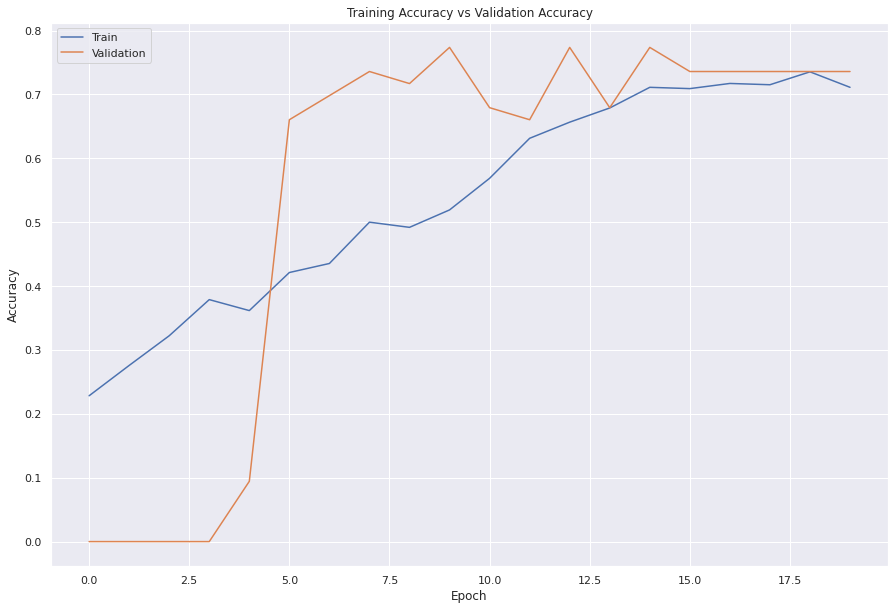

In [77]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

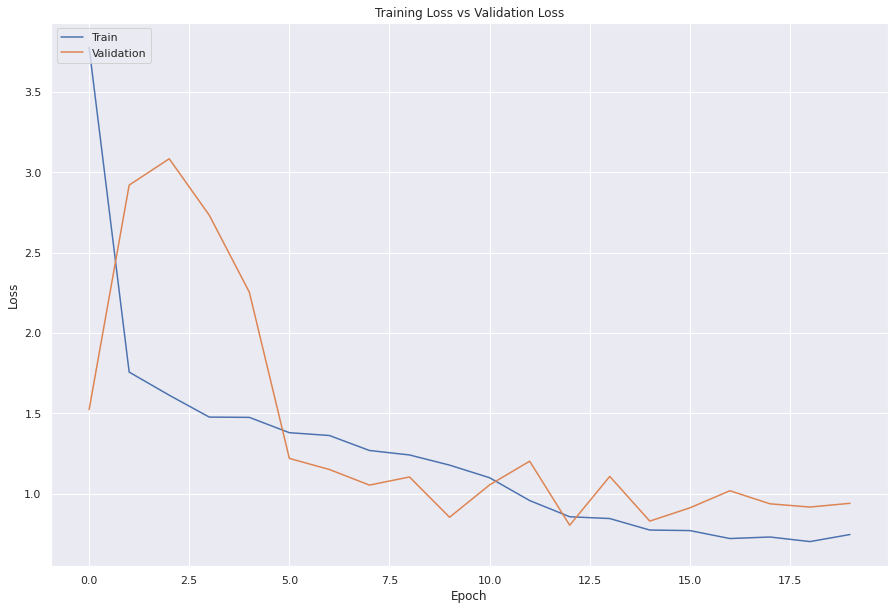

In [78]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [79]:
# Train
loss, acc = model.evaluate(x_train, y_train)
print('Train')
print(f'loss : {loss}')
print(f'acc : {acc*100}')

33/33 [==============================] - 1s 9ms/step - loss: 0.5701 - accuracy: 0.7919
Train
loss : 0.5701003074645996
acc : 79.1946291923523


In [80]:
# Test
loss, acc = model.evaluate(x_test, y_test)
print('Test')
print(f'loss : {loss}')
print(f'acc : {acc*100}')

4/4 [==============================] - 0s 34ms/step - loss: 0.9191 - accuracy: 0.7010
Test
loss : 0.9191375970840454
acc : 70.10309100151062


# Save model

In [81]:
model.save('/content/model.h5')

# Apply prescription

# image preprocessing

In [82]:
def preprocessing(img):
  img_size = 32
  image_array = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
  # get the width and height of image
  width, height = Image.open(img).size
  # to check if all image could resize
  try:
    resized_img = cv2.resize(image_array, (img_size, img_size))
  except:
    print('check size!')
  x = np.array(resized_img) / 255
  x = x.reshape(-1, img_size, img_size, 1)
  return x

# line segmentation for prescription

(1280, 765, 3)
(1280, 765, 3)


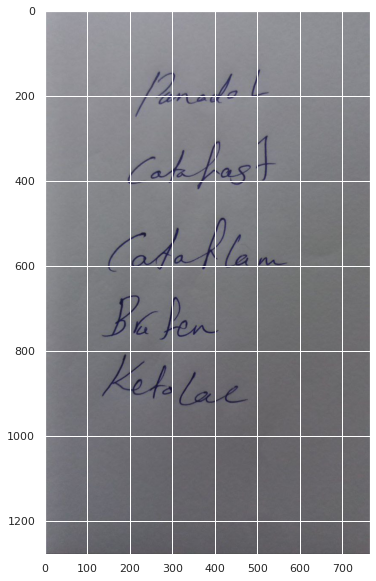

In [118]:
img = cv2.imread('/content/test.jpg') #read image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #imageFile is read with imread(), the order of colors is BGR, On the other hand, in Pillow, the order of colors is GB 

h, w, c = img.shape #height, width, channels 
print(img.shape)
if w > 1000: # width must longer than 1000
    new_w = 1000
    ar = w/h #to get the new height
    new_h = int(new_w/ar)
    
    img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)
print(img.shape)
plt.imshow(img);

In [119]:
def thresholding(image):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    #ret,thresh = cv2.threshold(img_gray, 120,255,cv2.THRESH_BINARY_INV)
    thresh = cv2.adaptiveThreshold(img_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
    # plt.imshow(thresh, cmap='gray')
    return thresh

In [120]:
blurred = cv2.GaussianBlur(img.copy(), (17, 17), 0)
thresh_img = thresholding(blurred);

In [121]:
kernel = np.ones((1,100), np.uint8) #matrix of ones on shape 3*85 in dataType unsigned int 
#print(kernel)
dilated = cv2.dilate(thresh_img, kernel, iterations = 1) #iteration is num of steps of kernal
# plt.imshow(dilated, cmap='gray');

In [122]:
(contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h) #1 mean sort vertically but 0 mean sort horizontally
print(sorted_contours_lines[0].shape)

(1071, 1, 2)


In [123]:
#img2 = img.copy()
sum_of_heights = 0
#sorted_contours_lines_2 = []
for ctr in sorted_contours_lines:
    x,y,w,h = cv2.boundingRect(ctr)  
    sum_of_heights += h 
mean_of_heights = sum_of_heights/len(sorted_contours_lines)

In [124]:
sum_of_spaces = 0
i=1
for ctr in sorted_contours_lines:
  if(i < len(sorted_contours_lines)):
    x,y,w,h = cv2.boundingRect(ctr)
    nx,ny,nw,nh = cv2.boundingRect(sorted_contours_lines[i])
    #sum_of_spaces += (y-(ny+nh))
    sum_of_spaces += (ny - (y+h))
    i +=1
mean_of_spaces = sum_of_spaces / (len(sorted_contours_lines)-1)

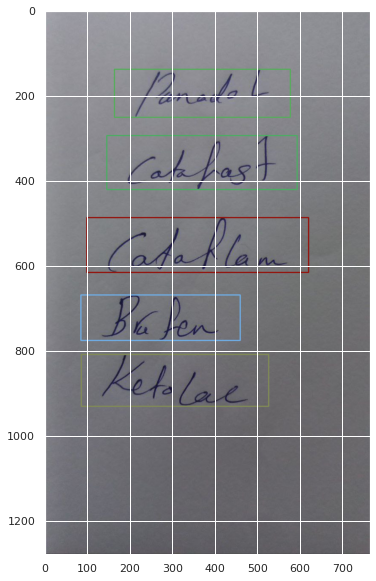

In [125]:
img3 = img.copy()
sorted_contours_lines_half_h = []

for ctr in sorted_contours_lines:
    #ctr= sorted_contours_lines[4]
    x,y,w,h = cv2.boundingRect(ctr)
    if(h < int(mean_of_heights/2)):
        continue
        
    cv2.rectangle(img3, (x,y), (x+w, y+h), (np.random.randint(255),np.random.randint(255),np.random.randint(255)), 2) #img, coordnate, area, color, bold
    sorted_contours_lines_half_h.append((x,y,w,h))
    #print(f"h {h} mean {mean_of_spaces}")
plt.imshow(img3);

# Save each image to colab files

In [126]:
%rm -rf /content/Lines5

In [127]:
crop_img = img.copy()
i=0
os.mkdir('/content/Lines5')
for ctr in sorted_contours_lines_half_h:
    x=ctr[0]
    y=ctr[1]
    w=ctr[2]
    h=ctr[3]
    #x,y,w,h = cv2.boundingRect(ctr)
    line = crop_img[y:h+y, x:w+x]
    print(str(x) + " " + str(y) +" "+str(w) +" "+str(h))
    cv2.imwrite(f"/content/Lines5/{i}.jpg", line)
    i+=1

163 139 414 113
145 295 448 127
98 488 522 129
84 670 375 107
85 810 441 122


# predict each image separately

In [128]:
for images in natsorted(os.listdir('/content/Lines5')):
  print(images)
  image = preprocessing(f'/content/Lines5/{images}')
  print('prob :', model.predict(image))
  predictions = np.argmax(model.predict(image), axis=-1)
  print(classes[predictions[0]])

0.jpg
1/1 [==============================] - 0s 17ms/step
prob : [[0.24917598 0.4616681  0.09468307 0.00786802 0.18660483]]
1/1 [==============================] - 0s 15ms/step
ketolac
1.jpg
1/1 [==============================] - 0s 15ms/step
prob : [[8.7983470e-04 2.9387366e-02 6.9388106e-02 8.1831130e-04 8.9952642e-01]]
1/1 [==============================] - 0s 17ms/step
cataflam
2.jpg
1/1 [==============================] - 0s 18ms/step
prob : [[0.0111066  0.11277853 0.08028658 0.00658098 0.7892473 ]]
1/1 [==============================] - 0s 16ms/step
cataflam
3.jpg
1/1 [==============================] - 0s 16ms/step
prob : [[0.01841921 0.1977512  0.05822874 0.00516071 0.72044015]]
1/1 [==============================] - 0s 17ms/step
cataflam
4.jpg
1/1 [==============================] - 0s 16ms/step
prob : [[0.17284758 0.38673085 0.07981134 0.01840207 0.3422082 ]]
1/1 [==============================] - 0s 17ms/step
ketolac
